In [ ]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

writer = tf.summary.FileWriter('./')

In [421]:
tf.reset_default_graph()

#####################
#     Constants     #
#####################

num_iterations = 10000

h = tf.constant(0.1)
c = tf.constant(0.1)
ve = tf.constant(0.)

decay_constant = tf.constant(0.1)
threshold = tf.constant(10.0)
reset = tf.constant(-3.)

neuron_types = ['BIN_IND', 'CIN_IND', 'PY_IND', 'TC_IND', 'PN_IND']
neuron_counts = [1, 1, 0, 0, 0]
neuron_type_indices = []
temp = 0
for i in range(len(neuron_types)):
    cum_sum = np.sum(neuron_counts[:i], dtype=np.int32)
    neuron_type_indices.append(np.linspace(temp, cum_sum -1, cum_sum-temp, dtype=np.int32))
    temp = cum_sum
num_neurons = np.sum(neuron_counts)


syn_cons = tf.constant(0.15)
syn_peak = tf.constant(50.0)


# INaK
G_K = tf.constant(18.)
E_K = tf.constant(-80.)
G_Na = tf.constant(45.)
E_Na = tf.constant(55.)
Phi = tf.constant(4.)

# ICa_ht
G_Ca = tf.constant(1.22)
V_Ca = tf.constant(120.)
half_value = tf.constant(20.)

# ICa
# ICa_ht=?, cai=?, r=?
alpha = tf.constant(0.005635716)
Tau_ca = tf.constant(28.3904)

# IKCa
# cai=?
g_AHP = tf.constant(5.)
K_D = tf.constant(30.)
V_k= tf.constant(-75.)

#### Sparse Matrix for Synapse Connections

In [422]:
syn_conecs = tf.SparseTensor(indices=[[1, 0]], values=[1.],
                             dense_shape=[num_neurons, num_neurons])

#### Single Step for a Neuron Layer

In [423]:
# Ion channel calculations
def fINaK(v, h, n):    
    Alpha1 = -0.1*(v+33)/(tf.exp(-0.1*(v+33)) - 1)
    Beta1 = 4*(tf.exp(-1*(v +58)/12))
    m_inf = Alpha1/(Alpha1 + Beta1)
    
    Alpha2 = 0.07*tf.exp(-1*(v+50)/10)
    Beta2 = 1/(tf.exp(-0.1*(v+20)) + 1)
    tau_h = 1/(Alpha2 + Beta2)
    h_inf = Alpha2/(Alpha2 + Beta2)
    
    Alpha3 = -0.01*(v+34)/(tf.exp(-0.1*(v+34)) - 1);
    Beta3 = 0.125*tf.exp(-1*(v+44)/25);
    tau_n = 1/(Alpha3 + Beta3);
    n_inf = Alpha3/(Alpha3 + Beta3);

    fh = Phi*(h_inf - h)/tau_h
    
    fn = Phi*(n_inf - n)/tau_n
    
    INa = G_Na*m_inf*m_inf*m_inf*h*(v - E_Na);
    Ik = G_K*n*n*n*n*(v - E_K);
    
    return INa, Ik

def fICa_ht(v):    

    m_inf = 1 / (1+ tf.exp(-(v+half_value)/9))
    ICa_ht = G_Ca*m_inf*m_inf*(v - V_Ca)
    
    return ICa_ht

def fICa(v):
    fcai = 2*(-alpha*ICa_ht - (cai/Tau_ca))/r
    return fcai

def fIKCa(v):
    IKCa = g_AHP * (cai / (cai + K_D)) * (v - V_k)
    return IKCa

In [424]:
# individual neuron calculations
def neuron(y_prev, current_input):
    y_out=c*(ve-y_prev[0]) + INa + Ik + current_input
    return y_out

def neuron_BIN_IND(y_prev, current_input):
    temp = fINaK(y_prev)
    y_out= c * (ve-y_prev[0]) + INa + Ik
    return temp

def neuron_CIN_IND(y_prev, current_input):
    temp = fINaK(y_prev)
    return temp

def neuron_PY_IND(y_prev, current_input):
    temp = fINaK(y_prev)
    return temp

def neuron_TC_IND(y_prev, current_input):
    temp = fINaK(y_prev)
    return temp

def neuron_PN_IND(y_prev, current_input):
    temp = fINaK(y_prev)
    return temp

# neuron function for each neuron type
function_types = [neuron, neuron, neuron, neuron, neuron]

In [425]:
def get_step_input(current_input, step_no):
    if step_no == 1:
        return current_input
    elif step_no > 1:
        return  decay_constant * current_input

In [426]:
def neuron_combined_steps(prev_state, ext_current):
    
    y_out_all = None

    for i in range(len(neuron_types)):
        y_prev = tf.gather(prev_state[0], neuron_type_indices[i])
        syn_prev = tf.gather(prev_state[1], neuron_type_indices[i]) + tf.gather(ext_current, neuron_type_indices[i])

        neuron = function_types[i]
        
        current_input = get_step_input(syn_prev, 1)
        step1 = neuron(y_prev, current_input)

        current_input = get_step_input(current_input, 2)
        step2 = neuron(step1*h/2, current_input)

        step3 = neuron(step2*h/2, current_input)

        current_input = get_step_input(current_input, 2)
        step4 = neuron(step3*h, current_input)

        y_out = 1/6*(step1 + 2*step2 + 2*step3 + step4)*h + y_prev

        if y_out_all is None:
            y_out_all = y_out
        else:
            y_out_all = tf.concat([y_out_all, y_out], axis=0)
    
    # synapase discharges
    syn_prev_all = prev_state[1]
    syn_out_all =  syn_cons * tf.sparse_tensor_dense_matmul(syn_conecs,
        tf.reshape(tf.where(tf.greater(y_out_all, threshold), syn_peak*tf.ones_like(y_out_all), syn_prev_all),
                   (num_neurons,1)))
    
    # peak thresholding for neuron outputs
    y_out_all = tf.where(tf.greater(y_out_all, threshold), reset*tf.ones_like(y_out_all), y_out_all)

    
    return [y_out_all, tf.reshape(syn_out_all,(num_neurons,))]

In [427]:
# inputs to the neurons
inp = 0.05
inputs = tf.Variable(np.array([[inp] + [0.]*(num_neurons-1)] * num_iterations), dtype=tf.float32)

# initial activations and the combined input from synaptic connections
initial_val = 20.
initial_state = [tf.Variable(np.array([initial_val]*num_neurons), dtype=tf.float32),
                 tf.Variable(np.array([0]*num_neurons), dtype=tf.float32)]

# recurrent execution. will iterate to the size of the inputs
out = tf.scan(neuron_combined_steps, inputs, initializer=initial_state)

In [428]:
%%time
# running the tensorflow graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)
    iteration_vals = sess.run(out)

CPU times: user 10.2 s, sys: 7.89 s, total: 18 s
Wall time: 8.44 s


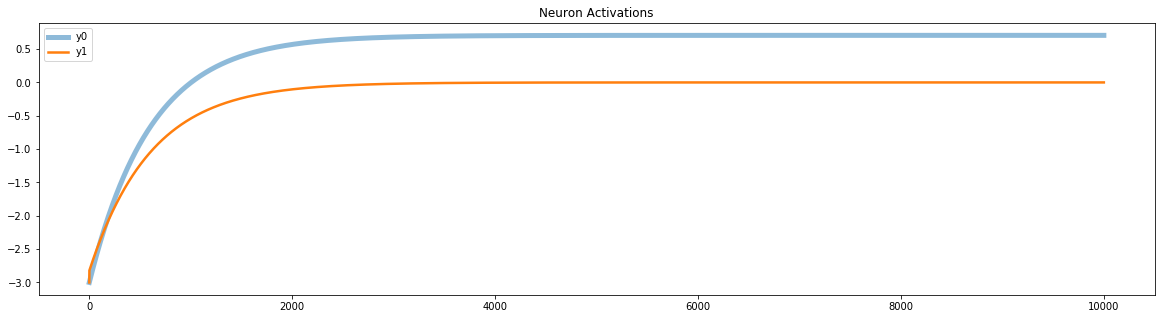

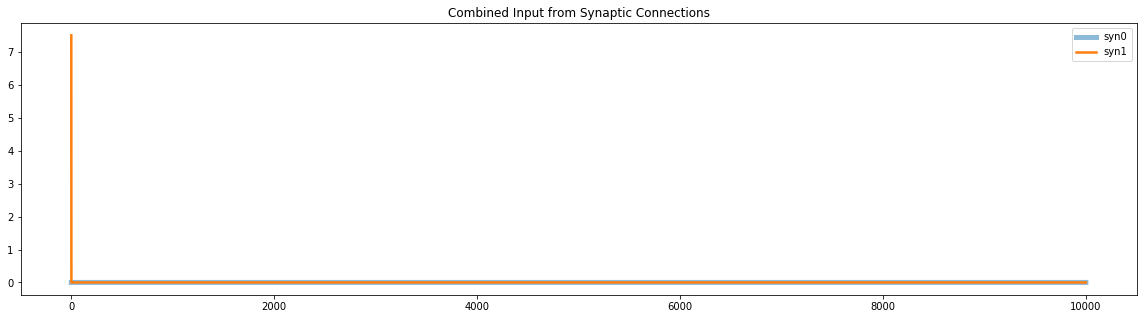

In [429]:
plt.figure(figsize=(20,5))
plt.title('Neuron Activations')
for i in range(num_neurons):
    plt.plot([y[i] for y in iteration_vals[0]], label='y'+str(i), alpha=(i+1.0)/(num_neurons),
             linewidth=5*(num_neurons-i)/(num_neurons))
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.title('Combined Input from Synaptic Connections')
for i in range(num_neurons):
    plt.plot([y[i] for y in iteration_vals[1]], label='syn'+str(i), alpha=(i+1.0)/(num_neurons),
             linewidth=5*(num_neurons-i)/(num_neurons))
plt.legend()
plt.show()